# 利用層次方法的平衡迭代規約和聚類(balanced iterative reducing and clustering using hierarchies)

##### 先引入我們需要的packages

In [1]:
import os 
import numpy as np
import scipy as sp
import numbers
import matplotlib.pyplot as plt
from numpy import random
from tqdm.notebook import tqdm
from scipy import sparse
from scipy.spatial.distance import cdist,pdist
from scipy.cluster import hierarchy

# MNIST Dataset

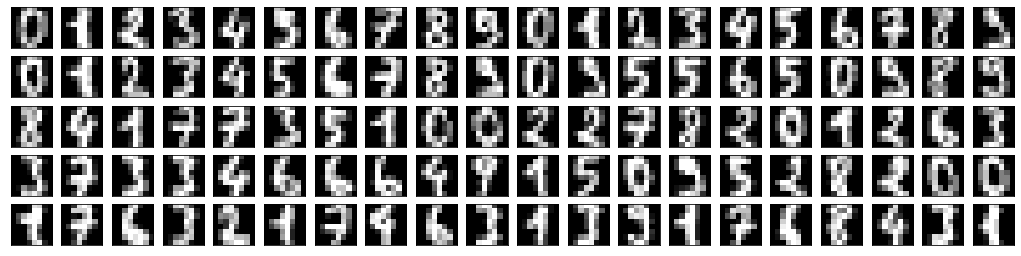

In [2]:
from sklearn.datasets import load_digits
digits = load_digits()
X=digits.data/16
y=digits.target
plt.rcParams["figure.figsize"] = (18,18)
plt.gray() 
for i in range(100):
    plt.subplot(20, 20, i + 1)
    plt.imshow(digits.images[i], cmap=plt.cm.gray, vmax=16, interpolation='nearest')
    plt.xticks(())
    plt.yticks(())
plt.show() 

# Principal Component Anlysis

In [3]:
def PCA(X,n_components,N):
    X_center=X-np.mean(X,axis=0)
    W,D,V=np.linalg.svd(X_center.T)
    X_embedded=np.dot(X_center,W[:,:n_components])
    return X_embedded
def row_norms(X,squared=False):
    norms = np.einsum("ij,ij->i", X, X)
    if not squared:
        np.sqrt(norms, norms)
    return norms

# Birch

In [4]:
class BIRCH:
    def __init__(self,*,threshold=0.5,branching_factor=50,n_clusters=3,compute_labels=True,copy=True,):
        self.threshold = threshold
        self.branching_factor = branching_factor
        self.n_clusters = n_clusters
        self.compute_labels = compute_labels
        self.copy = copy
    def fit(self,X):
        threshold = self.threshold
        branching_factor = self.branching_factor
        n_samples, n_features = X.shape
        self.root = CF_Node(threshold=threshold,branching_factor=branching_factor,
                            is_leaf=True,n_features=n_features)
        self.dummy_leaf = CF_Node(threshold=threshold,branching_factor=branching_factor,
                                  is_leaf=True,n_features=n_features)
        self.dummy_leaf.next_leaf = self.root
        self.root.prev_leaf = self.dummy_leaf
        iter_func = iter(X)
        for sample in iter_func:
            subcluster = CF_Subcluster(linear_sum=sample)
            split = self.root.insert_cf_subcluster(subcluster)
            if split:
                new_subcluster1, new_subcluster2 = split_node(self.root, threshold, branching_factor)
                del self.root
                self.root = CF_Node(threshold=threshold,branching_factor=branching_factor,
                                    is_leaf=False,n_features=n_features,)
                self.root.append_subcluster(new_subcluster1)
                self.root.append_subcluster(new_subcluster2)
        centroids = np.concatenate([leaf.centroids for leaf in self.get_leaves()])
        self.subcluster_centers = centroids
        self.global_clustering(X)
        return self
    def get_leaves(self):
        leaf_ptr = self.dummy_leaf.next_leaf
        leaves = []
        while leaf_ptr is not None:
            leaves.append(leaf_ptr)
            leaf_ptr = leaf_ptr.next_leaf
        return leaves
    def global_clustering(self, X):
        clusterer = self.n_clusters
        centroids = self.subcluster_centers
        compute_labels = (X is not None) and self.compute_labels
        if isinstance(clusterer, numbers.Integral):
            clusterer = AgglomerativeClustering(n_clusters=self.n_clusters)
        self.subcluster_norms = row_norms(self.subcluster_centers, squared=True)
        self.subcluster_labels = clusterer.fit_predict(self.subcluster_centers)
    def predict(self,X):
        dist = cdist(X,self.subcluster_centers,"sqeuclidean")
        argmin = np.argmin(dist,axis=1)
        return self.subcluster_labels[argmin]

# CF Node

In [5]:
class CF_Node:
    def __init__(self, *, threshold, branching_factor, is_leaf, n_features):
        self.threshold = threshold
        self.branching_factor = branching_factor
        self.is_leaf = is_leaf
        self.n_features = n_features
        self.subclusters = []
        self.init_centroids = np.zeros((branching_factor + 1, n_features))
        self.init_sq_norm = np.zeros((branching_factor + 1))
        self.squared_norm = []
        self.prev_leaf = None
        self.next_leaf = None
    def append_subcluster(self, subcluster):
        n_samples = len(self.subclusters)
        self.subclusters.append(subcluster)
        self.init_centroids[n_samples] = subcluster.centroid
        self.init_sq_norm[n_samples] = subcluster.sq_norm
        self.centroids = self.init_centroids[:n_samples+1,:]
        self.squared_norm = self.init_sq_norm[:n_samples+1]
    def update_split_subclusters(self, subcluster, new_subcluster1, new_subcluster2):
        ind = self.subclusters.index(subcluster)
        self.subclusters[ind] = new_subcluster1
        self.init_centroids[ind] = new_subcluster1.centroid
        self.init_sq_norm[ind] = new_subcluster1.sq_norm
        self.append_subcluster(new_subcluster2)
    def insert_cf_subcluster(self, subcluster):
        if not self.subclusters:
            self.append_subcluster(subcluster)
            return False
        threshold = self.threshold
        branching_factor = self.branching_factor
        dist_matrix = np.dot(self.centroids, subcluster.centroid)
        dist_matrix *= -2.0
        dist_matrix += self.squared_norm
        closest_index = np.argmin(dist_matrix)
        closest_subcluster = self.subclusters[closest_index]
        if closest_subcluster.child is not None:
            split_child = closest_subcluster.child.insert_cf_subcluster(subcluster)
            if not split_child:
                closest_subcluster.update(subcluster)
                self.init_centroids[closest_index] = self.subclusters[closest_index].centroid
                self.init_sq_norm[closest_index] = self.subclusters[closest_index].sq_norm
                return False
            else:
                new_subcluster1, new_subcluster2 = split_node(closest_subcluster.child,
                                                              threshold,branching_factor)
                self.update_split_subclusters(closest_subcluster,new_subcluster1,new_subcluster2)
                if len(self.subclusters) > self.branching_factor:
                    return True
                return False
        else:
            merged = closest_subcluster.merge_subcluster(subcluster, self.threshold)
            if merged:
                self.init_centroids[closest_index] = closest_subcluster.centroid
                self.init_sq_norm[closest_index] = closest_subcluster.sq_norm
                return False
            elif len(self.subclusters) < self.branching_factor:
                self.append_subcluster(subcluster)
                return False
            else:
                self.append_subcluster(subcluster)
                return True

# CF Subcluster

In [6]:
class CF_Subcluster:
    def __init__(self, *, linear_sum=None):
        if linear_sum is None:
            self.n_samples = 0
            self.squared_sum = 0.0
            self.centroid = self.linear_sum = 0
        else:
            self.n_samples = 1
            self.centroid = self.linear_sum = linear_sum
            self.squared_sum = self.sq_norm = np.dot(self.linear_sum, self.linear_sum)
        self.child = None
    def update(self, subcluster):
        self.n_samples += subcluster.n_samples
        self.linear_sum += subcluster.linear_sum
        self.squared_sum += subcluster.squared_sum
        self.centroid = self.linear_sum / self.n_samples
        self.sq_norm = np.dot(self.centroid, self.centroid)
    def merge_subcluster(self, nominee_cluster, threshold):
        new_ss = self.squared_sum + nominee_cluster.squared_sum
        new_ls = self.linear_sum + nominee_cluster.linear_sum
        new_n = self.n_samples + nominee_cluster.n_samples
        new_centroid = (1 / new_n) * new_ls
        new_sq_norm = np.dot(new_centroid, new_centroid)
        sq_radius = new_ss / new_n - new_sq_norm
        if (sq_radius <= threshold ** 2):
            (self.n_samples,self.linear_sum,self.squared_sum,self.centroid,self.sq_norm,
            ) = (new_n, new_ls, new_ss, new_centroid, new_sq_norm)
            return True
        return False

# Split Node

In [7]:
def split_node(node, threshold, branching_factor):
    new_subcluster1 = CF_Subcluster()
    new_subcluster2 = CF_Subcluster()
    new_node1 = CF_Node(threshold=threshold,branching_factor=branching_factor,
                        is_leaf=node.is_leaf,n_features=node.n_features)
    new_node2 = CF_Node(threshold=threshold,branching_factor=branching_factor,
                        is_leaf=node.is_leaf,n_features=node.n_features)
    new_subcluster1.child = new_node1
    new_subcluster2.child = new_node2
    if node.is_leaf:
        if node.prev_leaf is not None:
            node.prev_leaf.next_leaf = new_node1
        new_node1.prev_leaf = node.prev_leaf
        new_node1.next_leaf = new_node2
        new_node2.prev_leaf = new_node1
        new_node2.next_leaf = node.next_leaf
        if node.next_leaf is not None:
            node.next_leaf.prev_leaf = new_node2
    dist = cdist(node.centroids,node.centroids,"sqeuclidean")
    n_clusters = dist.shape[0]
    farthest_idx = np.unravel_index(dist.argmax(), (n_clusters, n_clusters))
    node1_dist, node2_dist = dist[(farthest_idx,)]
    node1_closer = node1_dist < node2_dist
    for idx, subcluster in enumerate(node.subclusters):
        if node1_closer[idx]:
            new_node1.append_subcluster(subcluster)
            new_subcluster1.update(subcluster)
        else:
            new_node2.append_subcluster(subcluster)
            new_subcluster2.update(subcluster)
    return new_subcluster1, new_subcluster2

# Ward Hierarchical Clustering

In [8]:
def ward_tree(z,index,num,N):
    index=int(index)
    if(index>N-1):
        index-=N
    else:
        return index
    if(num==0):
        return index
    else:
        left_index=ward_tree(z,z[index,0],num-1,N)
        right_index=ward_tree(z,z[index,1],num-1,N)
        return [left_index,right_index]
def flatten(index,table):
    if(type(index)!=type(0)):
        for idx in index:
            flatten(idx,table)
    else:
        table.append(index)
    return table
class AgglomerativeClustering:
    def __init__(self,*,n_clusters=3):
        self.n_clusters=n_clusters
    
    def fit_predict(self,X):
        N,M=X.shape
        x_condensed=pdist(X)
        z=hierarchy.ward(x_condensed)
        table=[N-2]
        for i in range(self.n_clusters):
            table.append(int(z[table[0],0]-N))
            table.append(int(z[table[0],1]-N))
            del table[0]
            tensor=list(np.argsort(z[table,3])[::-1])
            table=np.array(table)
            table=list(table[tensor])
        labels=np.zeros(N)
        for i in range(self.n_clusters):
            idx=ward_tree(z,table[i]+N,N,N)
            tab=flatten(idx,[])
            labels[tab]=i
        return labels

# Execute Algorithms

In [9]:
brc = BIRCH(n_clusters=10)
brc.fit(X)
labels=brc.predict(X)

# Plot

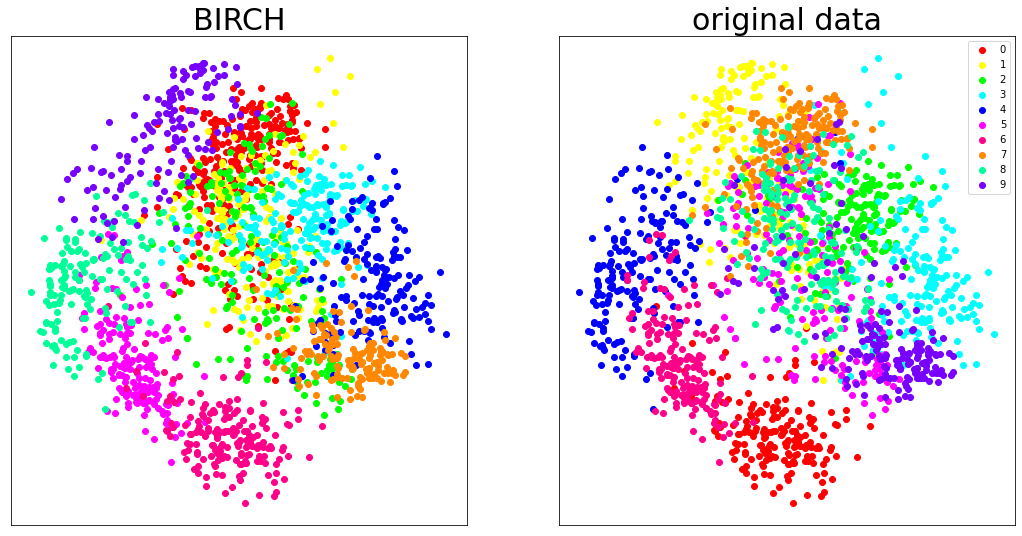

In [11]:
N,M=X.shape
X_embedded=PCA(X,2,N)
color=["#FF0000","#FFFF00","#00FF00","#00FFFF","#0000FF",
       "#FF00FF","#FF0088","#FF8800","#00FF99","#7700FF"]
plt.rcParams["figure.figsize"] = (18,9)
fig , ax = plt.subplots()
plt.subplot(1, 2, 1)
for i in range(0,10):
    BOOL=(labels==i)
    plt.scatter(X_embedded[BOOL,0],X_embedded[BOOL,1],c=color[i])
plt.title("BIRCH",fontsize=30)
plt.xticks([])
plt.yticks([])
plt.subplot(1, 2, 2)
for i in range(0,10):
    plt.scatter(X_embedded[(y==i),0],X_embedded[(y==i),1],c=color[i],label=i)
plt.title("original data",fontsize=30)
plt.xticks([])
plt.yticks([])
plt.legend(fontsize=10)
plt.show()